# Image Deconvolution example for 511 keV with spacecraft attitude binning 

updated on 2025-04-11

This notebook focuses on the image deconvolution with the spacecraft attitude (scatt) binning method. Using an older 511keV thin disk 3-month simulation data created for DC2, an example of the image analysis will be presented. If you have not run through 511keV-ScAtt-DataReduction.ipynb, please do that first as this analysis requires data that is binned slightly differently than the standard Galactic binning method shown in the DataIO tutorial.

In [1]:
import logging
import sys
logger = logging.getLogger('cosipy')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataIF_COSI_DC2, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

%matplotlib inline

15:02:02 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=438722;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=226407;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=939837;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=519440;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=731075;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=693195;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=309740;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=908665;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=697873;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=983647;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=112012;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=63965;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=327319;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=164183;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

15:02:02 WARNING   ROOT minimizer not available                                                ]8;id=220255;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=558499;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=668514;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=863342;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=211699;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=243399;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

15:02:03 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=746840;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=698004;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=941731;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=91161;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=156208;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=601043;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

15:02:03 WARNING   No fermitools installed                                              ]8;id=263126;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=76274;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=32013;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=616470;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=505415;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=312832;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=2892;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=512165;file:///Users/yoneda/Work/Exp/COSI/cosipy-2/cosipy-venv/cosipy-venv-20241022/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## 0. Files needed for this notebook

You should have used the 511keV-ScAtt-DataReduction.ipynb notebook to download and bin the data sets needed for this notebook. Specicially, you now should have:
- 511keV_dc2_scatt_bkg.hdf5
- 511keV_dc2_scatt_event.hdf5
- ccm_dc2.hdf5

From docs/tutorials/image_deconvolution/511keV/ScAttBinning, you will also need:
- inputs_511keV.yaml
- imagedeconvolution_parfile_scatt_511keV.yml


## 1. Read the response matrix

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [3]:
path_data = "/path/to/data/"

In [4]:
response_path = path_data + "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"

response = FullDetectorResponse.open(response_path)

In [5]:
response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/R_and_D/imaging/deconvolution/PR259/nb/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 3072
    NSIDE: 16
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 60
    EDGES: [0.0 deg, 3.0 deg, 6.0 deg, 9.0 deg, 12.0 deg, 15.0 deg, 18.0 deg, 21.0 deg, 24.0 deg, 27.0 deg, 30.0 deg, 33.0 deg, 36.0 deg, 39.0 deg, 42.0 deg, 45.0 deg, 48.0 deg, 51.0 deg, 54.0 deg, 57.0 deg, 60.0 deg, 63.0 deg, 66.0 deg, 69.0 deg, 72.0 deg, 75.0 deg, 78.0 deg, 81.0 deg, 84.0 deg, 87.0 deg, 90.0 deg, 93.0 de

## 2. Read binned 511keV binned files (source and background)

In [6]:
%%time

#  background 
data_bkg = BinnedData("inputs_511keV.yaml")
data_bkg.load_binned_data_from_hdf5("511keV_dc2_scatt_bkg.hdf5")

##  signal + background
data_511keV = BinnedData("inputs_511keV.yaml")
data_511keV.load_binned_data_from_hdf5("511keV_dc2_scatt_event.hdf5")

CPU times: user 141 ms, sys: 756 ms, total: 897 ms
Wall time: 906 ms


## 3. Load the coordsys conversion matrix

In [7]:
%%time

ccm = CoordsysConversionMatrix.open("ccm_dc2.hdf5")

CPU times: user 1.84 s, sys: 90.9 ms, total: 1.93 s
Wall time: 1.94 s


## 4. Imaging deconvolution

### Brief overview of the image deconvolution

Basically, we have to maximize the following likelihood function

$$
\log L = \sum_i X_i \log \epsilon_i - \sum_i \epsilon_i
$$

$X_i$: detected counts at $i$-th bin ( $i$ : index of the Compton Data Space)

$\epsilon_i = \sum_j R_{ij} \lambda_j + b_i$ : expected counts ( $j$ : index of the model space)

$\lambda_j$ : the model map (basically gamma-ray flux at $j$-th pixel)

$b_i$ : the background at $i$-th bin

$R_{ij}$ : the response matrix

Since we have to optimize the flux in each pixel, and the number of parameters is large, we adopt an iterative approach to find a solution of the above equation. The simplest one is the ML-EM (Maximum Likelihood Expectation Maximization) algorithm. It is also known as the Richardson-Lucy algorithm.

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \delta \lambda_{j}^{k}
$$
$$
\delta \lambda_{j}^{k} = \frac{\lambda_{j}^{k}}{\sum_{i} R_{ij}} \sum_{i} \left(\frac{ X_{i} }{\epsilon_{i}} - 1 \right) R_{ij} 
$$

We refer to $\delta \lambda_{j}^{k}$ as the delta map.

As for now, the two improved algorithms are implemented in COSIpy.

- Accelerated ML-EM algorithm (Knoedlseder+99)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \delta \lambda_{j}^{k}
$$
$$
\alpha^{k} < \mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k})
$$

Practically, in order not to accelerate the algorithm excessively, we set the maximum value of $\alpha$ ($\alpha_{\mathrm{max}}$). Then, $\alpha$ is calculated as:

$$
\alpha^{k} = \mathrm{min}(\mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k}), \alpha_{\mathrm{max}})
$$

- Noise damping using gaussian smoothing (Knoedlseder+05, Siegert+20)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \left[ w_j \delta \lambda_{j}^{k} \right]_{\mathrm{gauss}}
$$
$$
w_j = \left(\sum_{i} R_{ij}\right)^\beta
$$

$\left[ ... \right]_{\mathrm{gauss}}$ means that the differential image is smoothed by a gaussian filter.

## 4-1. Prepare DataInterface containing all necessary datasets

In [8]:
%%time

data_interface = DataIF_COSI_DC2.load(name = "511keV",
                                      event_binned_data = data_511keV.binned_data,
                                      dict_bkg_binned_data = {"albedo": data_bkg.binned_data},
                                      rsp = response,
                                      coordsys_conv_matrix=ccm,
                                      is_miniDC2_format=False)

Loading the response matrix onto your computer memory...
Finished
... checking the axis ScAtt of the event and background files...
    --> pass (edges)
... checking the axis Em of the event and background files...
    --> pass (edges)
... checking the axis Phi of the event and background files...
    --> pass (edges)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.
Calculating an exposure map...
Finished...
CPU times: user 8.43 s, sys: 1.73 s, total: 10.2 s
Wall time: 10.2 s


### 4-2. Initialize the instance of the image deconvolution class

First, we prepare an instance of the ImageDeconvolution class and then register the dataset and parameters for the deconvolution. After that, you can start the calculation.

<span style="color:red"> please modify this parameter_filepath corresponding to your environment.</span>

In [9]:
parameter_filepath = "imagedeconvolution_parfile_scatt_511keV.yml"

In [10]:
image_deconvolution = ImageDeconvolution()

# set data_interface to image_deconvolution
image_deconvolution.set_dataset([data_interface])

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

### Initialize image_deconvolution

In this process, a model map is defined following the input parameters, and it is initialized. Also, it prepares ancillary data for the image deconvolution, e.g., the expected counts with the initial model map, gaussian smoothing filter etc.

I describe parameters in the parameter file.

#### model_definition:class

Specify the name of the image class that will be used in the image deconvolution. As for now, it should be "AllSkyImage".

#### model_definition:property

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| coordinate | str | the coordinate system of the model map | As for now, it must be 'galactic' |
| nside | int | NSIDE of the model map | it must be the same as NSIDE of 'lb' axis of the coordinate conversion matrix|
| scheme | str | SCHEME of the model map | As for now, it must be 'ring' |
| energy_edges:value | list of float | The definition of the energy bins of the model map | As for now, it must be the same as that of the response matrix |
| energy_edges:unit | str | The physical unit of the above list | In most of cases, it is keV. |
| unit | str | The physical unit of the image | As for now, it should be ""cm-2 s-1 sr-1" |

#### model_definition:initialization

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| algorithm | str | the method name to initialize the model map | As for now, only 'flat' can be used |
| parameter_flat:value | list of float | the list of photon fluxes for each energy band | the length of the list should be the same as the length of "energy_edges" - 1 |
| parameter_flat:unit | str | The physical unit of the above list | As for now, it should be ""cm-2 s-1 sr-1" |

#### deconvolution

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
|algorithm | str | the name of the image deconvolution algorithm| As for now, only 'RL' is supported |
|||||
|parameter_RL:iteration_max | int | The maximum number of the iteration | |
|parameter_RL:acceleration:activate | bool | whether the accelerated ML-EM algorithm (Knoedlseder+99) is used | |
|parameter_RL:acceleration:alpha_max | float | the maximum value for the acceleration parameter | |
|parameter_RL:response_weighting:activate | bool | whether a delta map is renormalized based on the exposure time on each pixel, namely $w_j = (\sum_{i} R_{ij})^{\beta}$ (see Knoedlseder+05, Siegert+20) | |
|parameter_RL:response_weighting:index | float | $\beta$ in the above equation | |
|parameter_RL:smoothing:activate | bool | whether a Gaussian filter is used (see Knoedlseder+05, Siegert+20)  | |
|parameter_RL:smoothing:FWHM:value | float | the FWHM of the Gaussian in the filter | |
|parameter_RL:smoothing:FWHM:unit | str | the unit of the above value. deg. or rad. | |
|parameter_RL:background_normalization:activate | bool | whether the background normalization factor is optimized at each iteration | As for now, the single background normalization factor is used in all of the bins |
|parameter_RL:background_normalization:range | list of float | the range of the normalization factor | should be positive |
|parameter_RL:stopping_criteria:statistics | str | the statistics to be checked | In most of cases, it is "log-likelihood" |
|parameter_RL:stopping_criteria:threshold | float | the iteration is terminated when the increase of the selected statistics is below this value |  |
|parameter_RL:save_results:activate | bool | whether an updated model map, detal map, likelihood etc. are saved after the image deconvolution | |
|parameter_RL:save_results:directory | bool | the directory where the files are saved | |
|parameter_RL:save_results:only_final_result | bool | If True, only the result after the last iteration is saved | |

In [11]:
image_deconvolution.initialize()

#### Initialization Starts ####
<< Instantiating the model class AllSkyImage >>
---- parameters ----
coordinate: galactic
energy_edges:
  unit: keV
  value:
  - 509.0
  - 513.0
nside: 16
scheme: ring
unit: cm-2 s-1 sr-1

<< Setting initial values of the created model object >>
---- parameters ----
algorithm: flat
parameter:
  unit: cm-2 s-1 sr-1
  value:
  - 1e-4

<< Registering the deconvolution algorithm >>
Gaussian filter with FWHM of 2.0 deg will be applied to delta images ...
---- parameters ----
algorithm: RL
parameter:
  acceleration:
    activate: true
    alpha_max: 10.0
  background_normalization_optimization:
    activate: true
    range:
      albedo:
      - 0.01
      - 10.0
  iteration_max: 10
  response_weighting:
    activate: true
    index: 0.5
  save_results:
    activate: false
    directory: ./results
    only_final_result: true
  smoothing:
    FWHM:
      unit: deg
      value: 2.0
    activate: true
  stopping_criteria:
    statistics: log-likelihood
    thresh

### (You can change the parameters as follows)

Note that when you modify the parameters, do not forget to run "initialize" again!

In [12]:
image_deconvolution.override_parameter("deconvolution:parameter:iteration_max = 30")
image_deconvolution.override_parameter("deconvolution:parameter:background_normalization_optimization:activate = True")
image_deconvolution.override_parameter("deconvolution:parameter:acceleration:alpha_max = 10")
image_deconvolution.override_parameter("deconvolution:parameter:smoothing:FWHM:value = 3.0")

image_deconvolution.initialize()

#### Initialization Starts ####
<< Instantiating the model class AllSkyImage >>
---- parameters ----
coordinate: galactic
energy_edges:
  unit: keV
  value:
  - 509.0
  - 513.0
nside: 16
scheme: ring
unit: cm-2 s-1 sr-1

<< Setting initial values of the created model object >>
---- parameters ----
algorithm: flat
parameter:
  unit: cm-2 s-1 sr-1
  value:
  - 1e-4

<< Registering the deconvolution algorithm >>
Gaussian filter with FWHM of 3.0 deg will be applied to delta images ...
---- parameters ----
algorithm: RL
parameter:
  acceleration:
    activate: true
    alpha_max: 10
  background_normalization_optimization:
    activate: true
    range:
      albedo:
      - 0.01
      - 10.0
  iteration_max: 30
  response_weighting:
    activate: true
    index: 0.5
  save_results:
    activate: false
    directory: ./results
    only_final_result: true
  smoothing:
    FWHM:
      unit: deg
      value: 3.0
    activate: true
  stopping_criteria:
    statistics: log-likelihood
    threshol

## 4-3. Start the image deconvolution

**On a MacBook Pro with M2 Max and 96 GB memory, it takes about 2.5 min for 30 iterations.**

In [13]:
%%time

image_deconvolution.run_deconvolution()

#### Image Deconvolution Starts ####
<< Initialization >>
The response weighting filter was calculated.
The expected count histograms were calculated with the initial model map.


  0%|          | 0/30 [00:00<?, ?it/s]

## Iteration 1/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.5075995536022138
  background_normalization: {'albedo': 1.0048700233481953}
  log-likelihood: [-1563533.6769516869]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 2/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.5955357576855067
  background_normalization: {'albedo': 0.9944007425788672}
  log-likelihood: [-1516380.0670550964]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 3/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 10
  background_normalization: {'albedo': 1.0023392701256577}
  log-likelihood: [-1716848.8094231645]
<< Checking Stopping Criteria >>
The likelihood is not increased in this iteration. The image reconstruction may be unstable.
--> Continue
## Iteration 4/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9815828211261283}
  log-likelihood: [-1499240.8505021092]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 5/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9974314134771791}
  log-likelihood: [-1493104.2642669696]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 6/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.7172622610435744
  background_normalization: {'albedo': 0.9994578058499872}
  log-likelihood: [-1491569.8674703876]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 7/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998795059845245}
  log-likelihood: [-1490947.913693156]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 8/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.999769301217259}
  log-likelihood: [-1490447.9081130929]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 9/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997553620335473}
  log-likelihood: [-1490027.667825987]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 10/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997547962120401}
  log-likelihood: [-1489671.203587301]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 11/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.999755857521942}
  log-likelihood: [-1489366.4098961689]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 12/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997570463062043}
  log-likelihood: [-1489103.8516133537]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 13/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997581714826586}
  log-likelihood: [-1488876.0991178928]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 14/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997592144668066}
  log-likelihood: [-1488677.2578425317]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 15/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997601794042992}
  log-likelihood: [-1488502.6249046624]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 16/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997610680467861}
  log-likelihood: [-1488348.3838546188]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 17/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997618943356945}
  log-likelihood: [-1488211.4525220082]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 18/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.999762657607672}
  log-likelihood: [-1488089.281125763]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 19/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997633762092789}
  log-likelihood: [-1487979.788288923]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 20/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997640473889625}
  log-likelihood: [-1487881.2476708419]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 21/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997646735667173}
  log-likelihood: [-1487792.2005911968]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 22/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997652695476383}
  log-likelihood: [-1487711.4349080673]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 23/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997658319459374}
  log-likelihood: [-1487637.9342275572]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 24/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997663592912508}
  log-likelihood: [-1487570.8235164809]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 25/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997668585564661}
  log-likelihood: [-1487509.3673169948]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 26/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997673276318472}
  log-likelihood: [-1487452.9179179566]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 27/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997677761221316}
  log-likelihood: [-1487400.9592774352]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 28/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997681890221642}
  log-likelihood: [-1487353.0014308265]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 29/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997685812553364}
  log-likelihood: [-1487308.6169352506]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 30/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9997689635965462}
  log-likelihood: [-1487267.4392654886]
<< Checking Stopping Criteria >>
--> Stop
<< Finalization >>
#### Image Deconvolution Finished ####
CPU times: user 22min 2s, sys: 3min, total: 25min 3s
Wall time: 4min 9s


In [14]:
image_deconvolution.results

[{'iteration': 1,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0x3b7a87f10>,
  'delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0x3b7ac02b0>,
  'processed_delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0x3b7ac0100>,
  'background_normalization': {'albedo': 1.0048700233481953},
  'alpha': <Quantity 2.50759955>,
  'log-likelihood': [-1563533.6769516869]},
 {'iteration': 2,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0x3b7ac15d0>,
  'delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0x3b7ac1570>,
  'processed_delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0x3b7ac1030>,
  'background_normalization': {'albedo': 0.9944007425788672},
  'alpha': <Quantity 1.59553576>,
  'log-likelihood': [-1516380.0670550964]},
 {'iteration': 3,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0x3b7ae93c0>,
  'delta_model': <cosipy.im

## 5. Analyze the results
Examples to see/analyze the results are shown below.

### Log-likelihood

Plotting the log-likelihood vs the number of iterations

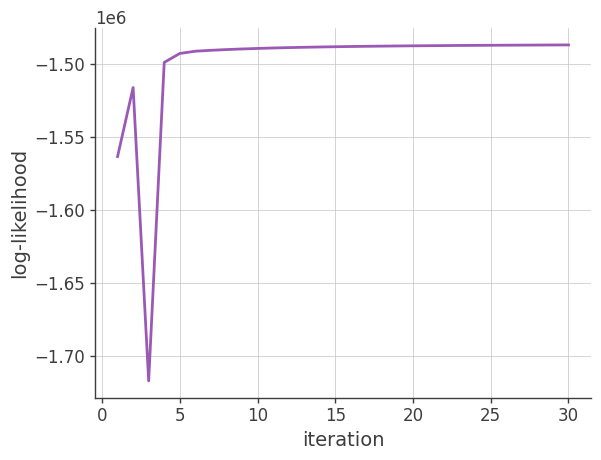

In [15]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['log-likelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.show()

### Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

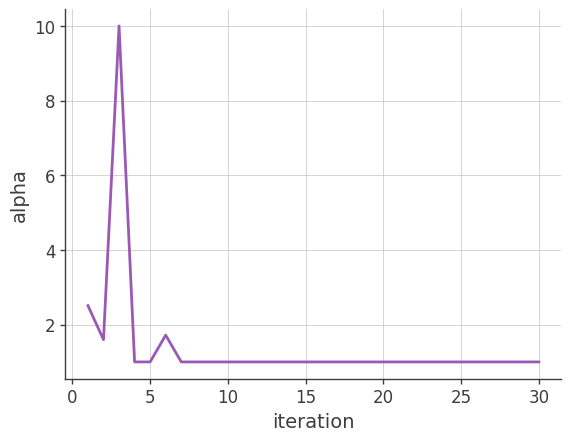

In [16]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")
plt.show()

### Background normalization

Plotting the background nomalization factor vs the number of iterations. If the background model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

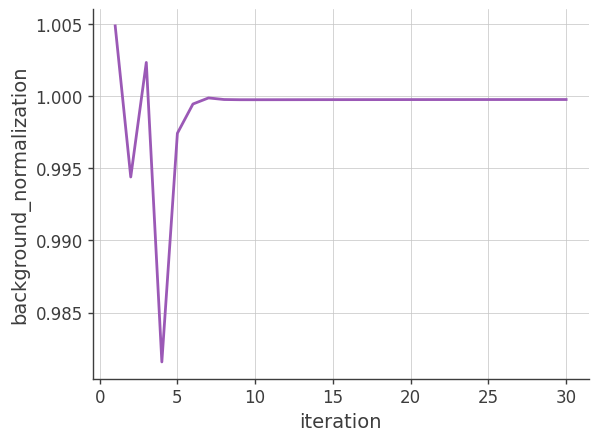

In [17]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['background_normalization']['albedo'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")
plt.show()

### The reconstructed images

In [18]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

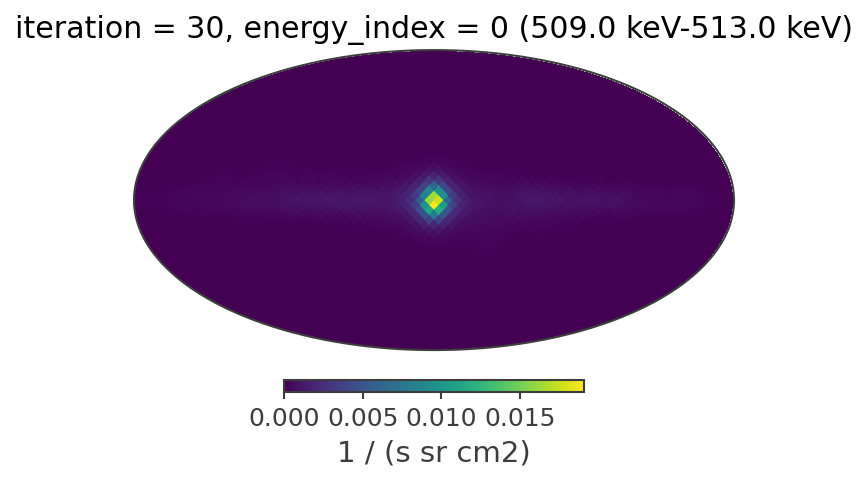

In [19]:
iteration = 29

plot_reconstructed_image(image_deconvolution.results[iteration])

An example to plot the image in the log scale

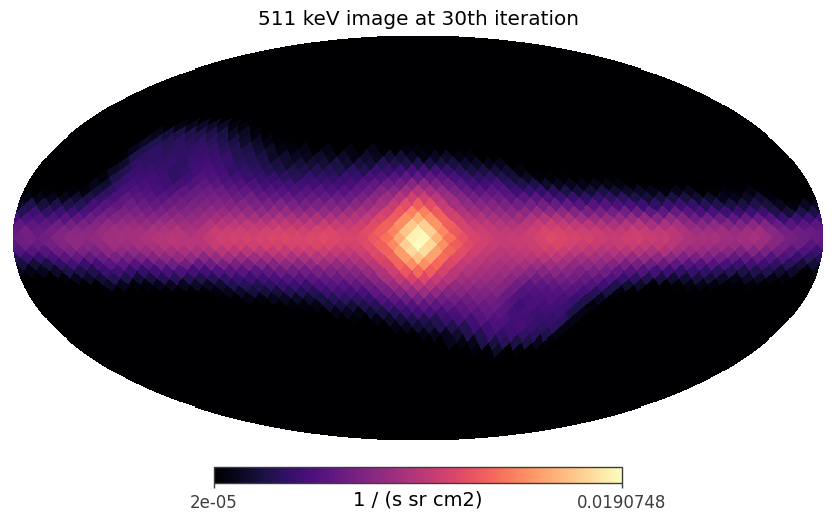

In [20]:
iteration_idx = 29

result = image_deconvolution.results[iteration_idx]

iteration = result['iteration']
image = result['model']

data = image[:,0]
data[data <= 0 * data.unit] = 1e-12 * data.unit

hp.mollview(data, min = 2e-5, norm ='log', unit = str(data.unit), title = f'511 keV image at {iteration}th iteration', cmap = 'magma')

plt.show()